In [39]:

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os

In [27]:

# U-Net Model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.bottleneck = CBR(512, 1024)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)
        
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        return torch.sigmoid(self.final_conv(dec1))

# Custom Dataset
class YUCARSDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        mask_path = os.path.join(self.mask_dir, self.img_names[idx])  # Assuming masks have the same name as images
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Assuming mask is a grayscale image

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [22]:
import torchvision

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load the dataset
dataset = torchvision.datasets.OxfordIIITPet(root='data', 
                                             split='trainval', 
                                             target_types='segmentation', 
                                             download=True, 
                                             transform=transform)

In [23]:

# Model, Loss, and Optimizer
model = UNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)


UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
  

In [24]:
import torchvision.datasets as datasets
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images and masks to 128x128
    transforms.ToTensor(),          # Convert both images and masks to tensors
])

dataset = datasets.OxfordIIITPet(
    root='data', 
    split='trainval', 
    target_types='segmentation', 
    download=True,
    transform=transform,            # Apply transformations to the images
    target_transform=transform      # Apply the same transformations to the segmentation masks
)
# Create a DataLoader for batching and shuffling
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)


In [25]:
dataset

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Target transform: Compose(
                      Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                      ToTensor()
                  )

In [18]:

from torch.utils.tensorboard import SummaryWriter

num_epochs = 200
writer = SummaryWriter('runs/unet_experiment')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        #print("test")
        outputs = model(images)
        
        #logits = outputs.logits
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        progress_bar.set_postfix(loss=running_loss/len(progress_bar))
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")
    if (epoch + 1) % 50 == 0:
        # 
        torch.save(model.state_dict(), f'weights/oxford_pet_{epoch+1}.pth')
        writer.add_images('input_images', images, epoch)
        writer.add_images('segmentation_masks', labels, epoch)
        writer.add_images('predictions', torch.sigmoid(outputs), epoch)


print("Finished Training")

Epoch 1/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.49batch/s, loss=0.0423]


Epoch [1/200], Loss: 0.042286320840534956


Epoch 2/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.60batch/s, loss=0.0422]


Epoch [2/200], Loss: 0.042241935885470844


Epoch 3/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.67batch/s, loss=0.0422]


Epoch [3/200], Loss: 0.042220074553852495


Epoch 4/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.63batch/s, loss=0.0422]


Epoch [4/200], Loss: 0.042202694098586624


Epoch 5/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.67batch/s, loss=0.0422]


Epoch [5/200], Loss: 0.04219430597579998


Epoch 6/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.70batch/s, loss=0.0422]


Epoch [6/200], Loss: 0.04218494639448497


Epoch 7/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.71batch/s, loss=0.0422]


Epoch [7/200], Loss: 0.042170912173131236


Epoch 8/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.64batch/s, loss=0.0422]


Epoch [8/200], Loss: 0.042167634646529735


Epoch 9/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.75batch/s, loss=0.0422]


Epoch [9/200], Loss: 0.042157982111625046


Epoch 10/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.65batch/s, loss=0.0422]


Epoch [10/200], Loss: 0.04215072352925073


Epoch 11/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.66batch/s, loss=0.0421]


Epoch [11/200], Loss: 0.042139777330600696


Epoch 12/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.65batch/s, loss=0.0421]


Epoch [12/200], Loss: 0.0421342681121567


Epoch 13/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.74batch/s, loss=0.0421]


Epoch [13/200], Loss: 0.04212392709501411


Epoch 14/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.68batch/s, loss=0.0421]


Epoch [14/200], Loss: 0.04212116509999918


Epoch 15/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.58batch/s, loss=0.0421]


Epoch [15/200], Loss: 0.042122733382427176


Epoch 16/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.57batch/s, loss=0.0421]


Epoch [16/200], Loss: 0.042111783247926964


Epoch 17/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.62batch/s, loss=0.0421]


Epoch [17/200], Loss: 0.04210008965886158


Epoch 18/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.50batch/s, loss=0.0421]


Epoch [18/200], Loss: 0.042093258675025856


Epoch 19/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.62batch/s, loss=0.0421]


Epoch [19/200], Loss: 0.04209099727804246


Epoch 20/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.07batch/s, loss=0.0421]


Epoch [20/200], Loss: 0.04208372395647609


Epoch 21/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.31batch/s, loss=0.0421]


Epoch [21/200], Loss: 0.04207943765365559


Epoch 22/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.40batch/s, loss=0.0421]


Epoch [22/200], Loss: 0.04207226180511972


Epoch 23/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.27batch/s, loss=0.0421]


Epoch [23/200], Loss: 0.04206988714311434


Epoch 24/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.68batch/s, loss=0.0421]


Epoch [24/200], Loss: 0.04206033538541068


Epoch 25/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  9.07batch/s, loss=0.0421]


Epoch [25/200], Loss: 0.04205611312518949


Epoch 26/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.47batch/s, loss=0.0421]


Epoch [26/200], Loss: 0.0420517372696296


Epoch 27/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.60batch/s, loss=0.0421]


Epoch [27/200], Loss: 0.04205081271736518


Epoch 28/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.25batch/s, loss=0.042]


Epoch [28/200], Loss: 0.042035912236441736


Epoch 29/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.64batch/s, loss=0.042]


Epoch [29/200], Loss: 0.04202836267650127


Epoch 30/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.00batch/s, loss=0.042]


Epoch [30/200], Loss: 0.04202485870084037


Epoch 31/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.41batch/s, loss=0.042]


Epoch [31/200], Loss: 0.042022559095336046


Epoch 32/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.76batch/s, loss=0.042]


Epoch [32/200], Loss: 0.042013683477821556


Epoch 33/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.83batch/s, loss=0.042]


Epoch [33/200], Loss: 0.04200660560442054


Epoch 34/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.14batch/s, loss=0.042]


Epoch [34/200], Loss: 0.04200280572733153


Epoch 35/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.59batch/s, loss=0.042]


Epoch [35/200], Loss: 0.04199606886376505


Epoch 36/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.72batch/s, loss=0.042]


Epoch [36/200], Loss: 0.04199320134585318


Epoch 37/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.57batch/s, loss=0.042]


Epoch [37/200], Loss: 0.041987346582438634


Epoch 38/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.01batch/s, loss=0.042]


Epoch [38/200], Loss: 0.04198031681387321


Epoch 39/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.67batch/s, loss=0.042]


Epoch [39/200], Loss: 0.041979979027224626


Epoch 40/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.38batch/s, loss=0.042]


Epoch [40/200], Loss: 0.041970950397460356


Epoch 41/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.58batch/s, loss=0.042]


Epoch [41/200], Loss: 0.041967733010001805


Epoch 42/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.43batch/s, loss=0.042]


Epoch [42/200], Loss: 0.04196507579282574


Epoch 43/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.20batch/s, loss=0.042]


Epoch [43/200], Loss: 0.041962835241271104


Epoch 44/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.08batch/s, loss=0.042]


Epoch [44/200], Loss: 0.041954330565488855


Epoch 45/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 10.99batch/s, loss=0.042]


Epoch [45/200], Loss: 0.04195340641814729


Epoch 46/200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.64batch/s, loss=0.042]


Epoch [46/200], Loss: 0.041953059933755706


Epoch 47/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.05batch/s, loss=0.0419]


Epoch [47/200], Loss: 0.041946715764377425


Epoch 48/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.48batch/s, loss=0.0419]


Epoch [48/200], Loss: 0.041941397037843


Epoch 49/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.50batch/s, loss=0.0419]


Epoch [49/200], Loss: 0.04193762576450472


Epoch 50/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.18batch/s, loss=0.0419]


Epoch [50/200], Loss: 0.04193746622489846


Epoch 51/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.79batch/s, loss=0.0419]


Epoch [51/200], Loss: 0.041935126370062


Epoch 52/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.44batch/s, loss=0.0419]


Epoch [52/200], Loss: 0.04193400049015232


Epoch 53/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.47batch/s, loss=0.0419]


Epoch [53/200], Loss: 0.04192760956028233


Epoch 54/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.84batch/s, loss=0.0419]


Epoch [54/200], Loss: 0.04192772332740866


Epoch 55/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.38batch/s, loss=0.0419]


Epoch [55/200], Loss: 0.041922493910659914


Epoch 56/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.40batch/s, loss=0.0419]


Epoch [56/200], Loss: 0.0419210960359677


Epoch 57/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.79batch/s, loss=0.0419]


Epoch [57/200], Loss: 0.04192104222981826


Epoch 58/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.64batch/s, loss=0.0419]


Epoch [58/200], Loss: 0.041916192128606464


Epoch 59/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.66batch/s, loss=0.0419]


Epoch [59/200], Loss: 0.041916151085625526


Epoch 60/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.11batch/s, loss=0.0419]


Epoch [60/200], Loss: 0.0419113191411547


Epoch 61/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.76batch/s, loss=0.0419]


Epoch [61/200], Loss: 0.041910027534417485


Epoch 62/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 10.97batch/s, loss=0.0419]


Epoch [62/200], Loss: 0.04191002641683039


Epoch 63/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.67batch/s, loss=0.0419]


Epoch [63/200], Loss: 0.041907655561099884


Epoch 64/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.80batch/s, loss=0.0419]


Epoch [64/200], Loss: 0.04191181348717731


Epoch 65/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.97batch/s, loss=0.0419]


Epoch [65/200], Loss: 0.04190923393420551


Epoch 66/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.89batch/s, loss=0.0419]


Epoch [66/200], Loss: 0.04190346352432085


Epoch 67/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.73batch/s, loss=0.0419]


Epoch [67/200], Loss: 0.04190179326612017


Epoch 68/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.18batch/s, loss=0.0419]


Epoch [68/200], Loss: 0.04190093905705473


Epoch 69/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.56batch/s, loss=0.0419]


Epoch [69/200], Loss: 0.04189881674297478


Epoch 70/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.69batch/s, loss=0.0419]


Epoch [70/200], Loss: 0.041897751860644504


Epoch 71/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  9.19batch/s, loss=0.0419]


Epoch [71/200], Loss: 0.041896714853203815


Epoch 72/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.68batch/s, loss=0.0419]


Epoch [72/200], Loss: 0.04189638727061126


Epoch 73/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.58batch/s, loss=0.0419]


Epoch [73/200], Loss: 0.04189742107106292


Epoch 74/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.30batch/s, loss=0.0419]


Epoch [74/200], Loss: 0.041895480113832845


Epoch 75/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 10.97batch/s, loss=0.0419]


Epoch [75/200], Loss: 0.04189304267258748


Epoch 76/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.55batch/s, loss=0.0419]


Epoch [76/200], Loss: 0.04189391338630863


Epoch 77/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 10.98batch/s, loss=0.0419]


Epoch [77/200], Loss: 0.04189341262630794


Epoch 78/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.48batch/s, loss=0.0419]


Epoch [78/200], Loss: 0.04189052398761978


Epoch 79/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.93batch/s, loss=0.0419]


Epoch [79/200], Loss: 0.04188916420807009


Epoch 80/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.04batch/s, loss=0.0419]


Epoch [80/200], Loss: 0.04189020503798257


Epoch 81/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:26<00:00,  8.76batch/s, loss=0.0419]


Epoch [81/200], Loss: 0.04189340451165386


Epoch 82/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.22batch/s, loss=0.0419]


Epoch [82/200], Loss: 0.04188782781686472


Epoch 83/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  9.07batch/s, loss=0.0419]


Epoch [83/200], Loss: 0.041886387700619906


Epoch 84/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.86batch/s, loss=0.0419]


Epoch [84/200], Loss: 0.04188569034247295


Epoch 85/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.12batch/s, loss=0.0419]


Epoch [85/200], Loss: 0.04188470234689505


Epoch 86/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.90batch/s, loss=0.0419]


Epoch [86/200], Loss: 0.041885409649947414


Epoch 87/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.45batch/s, loss=0.0419]


Epoch [87/200], Loss: 0.041884071817216664


Epoch 88/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.57batch/s, loss=0.0419]


Epoch [88/200], Loss: 0.0418839318110891


Epoch 89/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.33batch/s, loss=0.0419]


Epoch [89/200], Loss: 0.04188345924991629


Epoch 90/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.24batch/s, loss=0.0419]


Epoch [90/200], Loss: 0.0418826594300892


Epoch 91/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.78batch/s, loss=0.0419]


Epoch [91/200], Loss: 0.04188277938443682


Epoch 92/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.30batch/s, loss=0.0419]


Epoch [92/200], Loss: 0.04188216824246489


Epoch 93/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  9.06batch/s, loss=0.0419]


Epoch [93/200], Loss: 0.041881747673387114


Epoch 94/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.81batch/s, loss=0.0419]


Epoch [94/200], Loss: 0.04188101571863112


Epoch 95/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.66batch/s, loss=0.0419]


Epoch [95/200], Loss: 0.04188104913286541


Epoch 96/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.09batch/s, loss=0.0419]


Epoch [96/200], Loss: 0.04188011277305043


Epoch 97/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.16batch/s, loss=0.0419]


Epoch [97/200], Loss: 0.04188020538700663


Epoch 98/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  9.07batch/s, loss=0.0419]


Epoch [98/200], Loss: 0.041879567941245824


Epoch 99/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.48batch/s, loss=0.0419]


Epoch [99/200], Loss: 0.041880092996618025


Epoch 100/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  9.19batch/s, loss=0.0419]


Epoch [100/200], Loss: 0.04189485413548739


Epoch 101/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.68batch/s, loss=0.0419]


Epoch [101/200], Loss: 0.041884774860480554


Epoch 102/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:27<00:00,  8.50batch/s, loss=0.0419]


Epoch [102/200], Loss: 0.04187978025039901


Epoch 103/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.74batch/s, loss=0.0419]


Epoch [103/200], Loss: 0.041878079380030214


Epoch 104/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.46batch/s, loss=0.0419]


Epoch [104/200], Loss: 0.04187739026611266


Epoch 105/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.40batch/s, loss=0.0419]


Epoch [105/200], Loss: 0.04187743903502174


Epoch 106/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.83batch/s, loss=0.0419]


Epoch [106/200], Loss: 0.04187675507172294


Epoch 107/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.96batch/s, loss=0.0419]


Epoch [107/200], Loss: 0.041876680841264516


Epoch 108/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.44batch/s, loss=0.0419]


Epoch [108/200], Loss: 0.04187675215627836


Epoch 109/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.40batch/s, loss=0.0419]


Epoch [109/200], Loss: 0.04187709091474181


Epoch 110/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.80batch/s, loss=0.0419]


Epoch [110/200], Loss: 0.04187688566744328


Epoch 111/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  9.12batch/s, loss=0.0419]


Epoch [111/200], Loss: 0.04187640128252299


Epoch 112/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.86batch/s, loss=0.0419]


Epoch [112/200], Loss: 0.04187600565669329


Epoch 113/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.89batch/s, loss=0.0419]


Epoch [113/200], Loss: 0.041875811682447146


Epoch 114/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.05batch/s, loss=0.0419]


Epoch [114/200], Loss: 0.04187542491632959


Epoch 115/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.72batch/s, loss=0.0419]


Epoch [115/200], Loss: 0.041875260064135424


Epoch 116/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.19batch/s, loss=0.0419]


Epoch [116/200], Loss: 0.04187538231844488


Epoch 117/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.56batch/s, loss=0.0419]


Epoch [117/200], Loss: 0.04187522601822148


Epoch 118/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.56batch/s, loss=0.0419]


Epoch [118/200], Loss: 0.04187513293455476


Epoch 119/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.12batch/s, loss=0.0419]


Epoch [119/200], Loss: 0.041874858963748686


Epoch 120/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.44batch/s, loss=0.0419]


Epoch [120/200], Loss: 0.04187448648330958


Epoch 121/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.29batch/s, loss=0.0419]


Epoch [121/200], Loss: 0.04187454906818659


Epoch 122/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.01batch/s, loss=0.0419]


Epoch [122/200], Loss: 0.04187449224941109


Epoch 123/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  8.91batch/s, loss=0.0419]


Epoch [123/200], Loss: 0.04187402681488058


Epoch 124/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.49batch/s, loss=0.0419]


Epoch [124/200], Loss: 0.0418740290986455


Epoch 125/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.21batch/s, loss=0.0419]


Epoch [125/200], Loss: 0.04187388392570226


Epoch 126/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.67batch/s, loss=0.0419]


Epoch [126/200], Loss: 0.041873727690266524


Epoch 127/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.57batch/s, loss=0.0419]


Epoch [127/200], Loss: 0.041873450528668324


Epoch 128/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.10batch/s, loss=0.0419]


Epoch [128/200], Loss: 0.041873553848784904


Epoch 129/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.62batch/s, loss=0.0419]


Epoch [129/200], Loss: 0.04187309852112894


Epoch 130/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.06batch/s, loss=0.0419]


Epoch [130/200], Loss: 0.04187314165351184


Epoch 131/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.38batch/s, loss=0.0419]


Epoch [131/200], Loss: 0.04187310331541559


Epoch 132/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.33batch/s, loss=0.0419]


Epoch [132/200], Loss: 0.04187273904681206


Epoch 133/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.44batch/s, loss=0.0419]


Epoch [133/200], Loss: 0.04187270709030006


Epoch 134/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.26batch/s, loss=0.0419]


Epoch [134/200], Loss: 0.04187302955466768


Epoch 135/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:27<00:00,  8.40batch/s, loss=0.0419]


Epoch [135/200], Loss: 0.041873011948621794


Epoch 136/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.35batch/s, loss=0.0419]


Epoch [136/200], Loss: 0.04187246034650699


Epoch 137/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:26<00:00,  8.58batch/s, loss=0.0419]


Epoch [137/200], Loss: 0.04187228618108708


Epoch 138/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.84batch/s, loss=0.0419]


Epoch [138/200], Loss: 0.04187218660245771


Epoch 139/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  9.01batch/s, loss=0.0419]


Epoch [139/200], Loss: 0.041872058355289954


Epoch 140/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.49batch/s, loss=0.0419]


Epoch [140/200], Loss: 0.04187193153345067


Epoch 141/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  9.02batch/s, loss=0.0419]


Epoch [141/200], Loss: 0.04187185229814571


Epoch 142/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.22batch/s, loss=0.0419]


Epoch [142/200], Loss: 0.0418718876398128


Epoch 143/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.39batch/s, loss=0.0419]


Epoch [143/200], Loss: 0.04187160237975743


Epoch 144/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.10batch/s, loss=0.0419]


Epoch [144/200], Loss: 0.041871962388572485


Epoch 145/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  8.86batch/s, loss=0.0419]


Epoch [145/200], Loss: 0.04187162000200023


Epoch 146/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.19batch/s, loss=0.0419]


Epoch [146/200], Loss: 0.04187129870381044


Epoch 147/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.39batch/s, loss=0.0419]


Epoch [147/200], Loss: 0.041871214058736096


Epoch 148/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.53batch/s, loss=0.0419]


Epoch [148/200], Loss: 0.04187110121483388


Epoch 149/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.39batch/s, loss=0.0419]


Epoch [149/200], Loss: 0.041871045999552894


Epoch 150/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.33batch/s, loss=0.0419]


Epoch [150/200], Loss: 0.041870968967028285


Epoch 151/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.38batch/s, loss=0.0419]


Epoch [151/200], Loss: 0.04187090604201607


Epoch 152/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.68batch/s, loss=0.0419]


Epoch [152/200], Loss: 0.04187090727298156


Epoch 153/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.98batch/s, loss=0.0419]


Epoch [153/200], Loss: 0.04187080332118532


Epoch 154/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.77batch/s, loss=0.0419]


Epoch [154/200], Loss: 0.04187055312744949


Epoch 155/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.86batch/s, loss=0.0419]


Epoch [155/200], Loss: 0.0418704292372517


Epoch 156/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.65batch/s, loss=0.0419]


Epoch [156/200], Loss: 0.04187041069178478


Epoch 157/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  9.05batch/s, loss=0.0419]


Epoch [157/200], Loss: 0.041870391789985736


Epoch 158/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.09batch/s, loss=0.0419]


Epoch [158/200], Loss: 0.041870230031402215


Epoch 159/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.51batch/s, loss=0.0419]


Epoch [159/200], Loss: 0.04187013200767662


Epoch 160/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:27<00:00,  8.44batch/s, loss=0.0419]


Epoch [160/200], Loss: 0.041870087239405385


Epoch 161/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:19<00:00, 11.52batch/s, loss=0.0419]


Epoch [161/200], Loss: 0.041870360270790434


Epoch 162/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.70batch/s, loss=0.0419]


Epoch [162/200], Loss: 0.041870194074252375


Epoch 163/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.82batch/s, loss=0.0419]


Epoch [163/200], Loss: 0.041870035862793094


Epoch 164/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  8.98batch/s, loss=0.0419]


Epoch [164/200], Loss: 0.04186982533530049


Epoch 165/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.68batch/s, loss=0.0419]


Epoch [165/200], Loss: 0.0418698888272047


Epoch 166/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:27<00:00,  8.35batch/s, loss=0.0419]


Epoch [166/200], Loss: 0.04186971158437107


Epoch 167/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.19batch/s, loss=0.0419]


Epoch [167/200], Loss: 0.04186963435748349


Epoch 168/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:26<00:00,  8.69batch/s, loss=0.0419]


Epoch [168/200], Loss: 0.04186971121184204


Epoch 169/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.48batch/s, loss=0.0419]


Epoch [169/200], Loss: 0.04186977781355381


Epoch 170/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.25batch/s, loss=0.0419]


Epoch [170/200], Loss: 0.041869574315522025


Epoch 171/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.73batch/s, loss=0.0419]


Epoch [171/200], Loss: 0.04186948827751305


Epoch 172/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  9.02batch/s, loss=0.0419]


Epoch [172/200], Loss: 0.04186941704348378


Epoch 173/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:26<00:00,  8.67batch/s, loss=0.0419]


Epoch [173/200], Loss: 0.04187785848651243


Epoch 174/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.16batch/s, loss=0.0419]


Epoch [174/200], Loss: 0.041874873330411705


Epoch 175/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.38batch/s, loss=0.0419]


Epoch [175/200], Loss: 0.041870568595502686


Epoch 176/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.32batch/s, loss=0.0419]


Epoch [176/200], Loss: 0.04186951105037461


Epoch 177/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  9.04batch/s, loss=0.0419]


Epoch [177/200], Loss: 0.041869177701680554


Epoch 178/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.73batch/s, loss=0.0419]


Epoch [178/200], Loss: 0.04186905873534472


Epoch 179/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.56batch/s, loss=0.0419]


Epoch [179/200], Loss: 0.041869017854332925


Epoch 180/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.13batch/s, loss=0.0419]


Epoch [180/200], Loss: 0.041869189444443455


Epoch 181/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.39batch/s, loss=0.0419]


Epoch [181/200], Loss: 0.04186882525682449


Epoch 182/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.26batch/s, loss=0.0419]


Epoch [182/200], Loss: 0.041868754217158195


Epoch 183/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.28batch/s, loss=0.0419]


Epoch [183/200], Loss: 0.04186887561303118


Epoch 184/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.17batch/s, loss=0.0419]


Epoch [184/200], Loss: 0.041868739882889


Epoch 185/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:27<00:00,  8.44batch/s, loss=0.0419]


Epoch [185/200], Loss: 0.04186867428538592


Epoch 186/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.33batch/s, loss=0.0419]


Epoch [186/200], Loss: 0.041868635655745216


Epoch 187/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:27<00:00,  8.47batch/s, loss=0.0419]


Epoch [187/200], Loss: 0.04186868376058081


Epoch 188/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.82batch/s, loss=0.0419]


Epoch [188/200], Loss: 0.041868631849470345


Epoch 189/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:23<00:00,  9.72batch/s, loss=0.0419]


Epoch [189/200], Loss: 0.04186854551991691


Epoch 190/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:24<00:00,  9.47batch/s, loss=0.0419]


Epoch [190/200], Loss: 0.04186858810160471


Epoch 191/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:22<00:00, 10.12batch/s, loss=0.0419]


Epoch [191/200], Loss: 0.04186864496897096


Epoch 192/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  8.96batch/s, loss=0.0419]


Epoch [192/200], Loss: 0.041868394710447475


Epoch 193/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.76batch/s, loss=0.0419]


Epoch [193/200], Loss: 0.04186847410772158


Epoch 194/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:27<00:00,  8.46batch/s, loss=0.0419]


Epoch [194/200], Loss: 0.04186843343726967


Epoch 195/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.30batch/s, loss=0.0419]


Epoch [195/200], Loss: 0.041868336093814476


Epoch 196/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:26<00:00,  8.75batch/s, loss=0.0419]


Epoch [196/200], Loss: 0.04186833285443161


Epoch 197/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:20<00:00, 11.38batch/s, loss=0.0419]


Epoch [197/200], Loss: 0.04186827859476856


Epoch 198/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:27<00:00,  8.44batch/s, loss=0.0419]


Epoch [198/200], Loss: 0.04186818773007911


Epoch 199/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:25<00:00,  9.09batch/s, loss=0.0419]


Epoch [199/200], Loss: 0.04186819053214529


Epoch 200/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:21<00:00, 10.60batch/s, loss=0.0419]


Epoch [200/200], Loss: 0.04186819968340189
Finished Training


# Evalute


In [28]:
import torch
import torch.nn as nn

# Assuming your U-Net class is already defined
# Load the model
model = UNet()  # Initialize your model (match with the architecture)
model.load_state_dict(torch.load('weights/oxford_pet_200.pth'))  # Load the trained model weights
model.eval()  # Set the model to evaluation mode

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
  

In [31]:
from PIL import Image
import numpy as np
from torchvision import transforms

# Assuming test image and ground truth are stored as .png or .jpg files
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match the input size expected by U-Net
    transforms.ToTensor()           # Convert image to PyTorch tensor
])

# Load test image and ground truth mask
test_image = Image.open('data/oxford-iiit-pet/images/Abyssinian_10.jpg').convert('RGB')  # Replace with your image path
test_mask = Image.open('data/oxford-iiit-pet/annotations/trimaps/Abyssinian_10.png').convert('L')      # Ground truth mask (binary or multi-class)

# Transform images
test_image_tensor = transform(test_image).unsqueeze(0)  # Add batch dimension
test_mask_tensor = transform(test_mask).squeeze(0)  # No batch dimension needed for mask

In [33]:
# Move tensor to the same device as the model (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
test_image_tensor = test_image_tensor.to(device)

# Make predictions
with torch.no_grad():
    predicted_mask = model(test_image_tensor)

# Convert predicted mask back to a format suitable for visualization
predicted_mask = torch.sigmoid(predicted_mask)  # Apply sigmoid to get probability map for binary segmentation
predicted_mask = predicted_mask.squeeze().cpu().numpy()  # Remove batch and move to CPU for numpy
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Apply threshold for binary mask

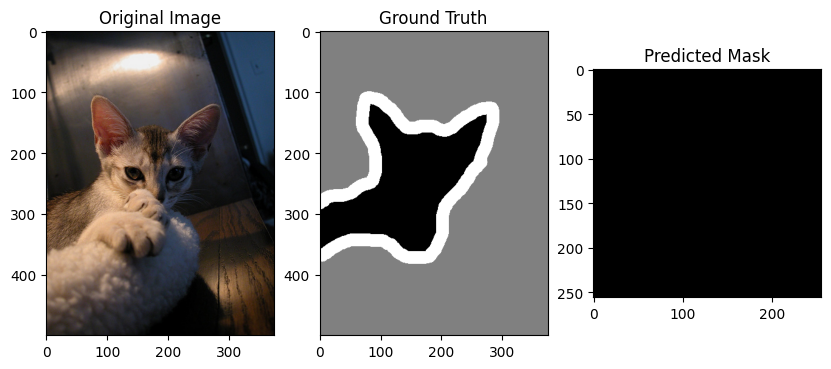

In [34]:
import matplotlib.pyplot as plt

def visualize_segmentation(original_image, ground_truth, predicted_mask):
    plt.figure(figsize=(10, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth, cmap='gray')
    plt.title('Ground Truth')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

# Convert the test image and test mask from tensors to numpy arrays for visualization
original_image_np = np.array(test_image)
ground_truth_np = np.array(test_mask)

# Visualize
visualize_segmentation(original_image_np, ground_truth_np, predicted_mask)

In [37]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a smaller size for quick evaluation
    transforms.ToTensor()
])

# Load the OxfordIIITPet dataset (using the segmentation target)
dataset = datasets.OxfordIIITPet(root='./data', split='test', target_types='segmentation', download=True, transform=transform, target_transform=transform)

# Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

# Define number of classes (background, pet, pet outline)
num_classes = 3

# Evaluate the model
iou_scores = []
pixel_accuracies = []


In [41]:
def compute_metrics(output, target, num_classes):
    smooth = 1e-10  # To avoid division by zero

    # Predicted mask
    pred = torch.argmax(output, dim=1)

    iou_per_class = []
    pixel_accuracy_per_class = []

    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).float().sum()  # TP
        union = ((pred == cls) | (target == cls)).float().sum()  # TP + FP + FN
        iou = (intersection + smooth) / (union + smooth)  # IoU

        correct_pixels = (pred == target).float().sum()
        total_pixels = torch.numel(target)
        pixel_accuracy = correct_pixels / total_pixels

        iou_per_class.append(iou.item())
        pixel_accuracy_per_class.append(pixel_accuracy.item())

    # Mean IoU and Mean Pixel Accuracy
    mean_iou = np.mean(iou_per_class)
    mean_pixel_accuracy = np.mean(pixel_accuracy_per_class)

    return mean_iou, mean_pixel_accuracy


In [42]:

with torch.no_grad():
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device).squeeze(1).long()  # Convert masks to long for loss calculation

        # Get model predictions
        outputs = model(images)

        # Resize the outputs to match the mask dimensions (if needed)
        outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

        # Calculate IoU and Pixel Accuracy
        iou, pixel_accuracy = compute_metrics(outputs, masks, num_classes)

        iou_scores.append(iou)
        pixel_accuracies.append(pixel_accuracy)

# Calculate mean IoU and Pixel Accuracy
mean_iou = np.mean(iou_scores)
mean_pixel_accuracy = np.mean(pixel_accuracies)

print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")

Mean IoU: 1.0000
Mean Pixel Accuracy: 1.0000
